### Program written by Scott Midgley, 2021
 Scope: To train and test MLP models for band gap energy screening in the configuraional space of MgO-ZnO solid solutions. 

In [1]:
### USER INPUT REQUIRED ###

# Please paste in the path to the repositiory here an comment/uncomment as needed.
# E.g. rundir = r'C:\Users\<user>\Desktop\repository'

# Windows path
#repodir = r'<windows\path\here>'

#Unix path
#repodir = '<unix/path/here>'
repodir = r'/home/mts87985/ml-thermo/Machine-Learning-for-Solid-Solutions/'

In [2]:
### USER INPUT REQUIRED ###

# Define percentage of training data to use for training. 
split = 10
#split = 50
#split = 80
#split = 30

In [3]:
# Import modules.
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam #Stochasic gradient descent method optimising weights and activations
import copy
from tensorflow.keras.callbacks import ModelCheckpoint
import time
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
import pickle
import os

In [4]:
def mlp_shallow(dropout_rate=0.1):
    # Define MLP architecture. 
    model = Sequential()
    model.add(Dense(64, input_dim=Xtrain[0].shape[0], activation='relu'))
    model.add(BatchNormalization())
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    return model
    
def mlp_deep(dropout_rate=0.1):
    model = Sequential()
    model.add(Dense(256, input_dim=Xtrain[0].shape[0], activation='relu')) #Set 128 standard neurons with relu initial activation
    model.add(BatchNormalization())
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    return model
    

In [5]:
# Clear any existing Tensorflow data from cache.
tf.keras.backend.clear_session()

## Load the data

Note we do not shuffle in this case. The data was shuffled when created and we are keeping it un-shuffled here so that the order is the same as that used in the paper. However, you are free to add a shuffle if you like.

In [6]:
# Import data and shuffle (optional).
eners = pd.read_pickle(repodir + 'repository-data/coulomb_matrix/input_data_cme.pkl')
#eners = eners.sample(frac=1)

In [7]:
# Split data frame into training, validation, and testing data. 
if split == int(10):
    e_train = eners.iloc[1608:2412] #10% of data for training
elif split == int(30):
    e_train = eners.iloc[1608:4021] #30% of data for training
elif split == int(50):
    e_train = eners.iloc[1608:5630] #50% of data for training
elif split == int(80):
    e_train = eners.iloc[1608:] #80% of data for training
else:
    print('Error: please choose a valid train/test split.')
e_val = eners.iloc[804:1608] #10% of data for validation
e_test = eners.iloc[:804] #10% of data for testing model

In [8]:
# Print number of training data points
print('Number of training data points = ', len(e_train))
# Convert Pandas columns to Numpy arrays. Reshaping to obtain array of nested brackets. 
Xtrain = e_train['Coulomb'].to_numpy()
ytrain = e_train['BGE'].to_numpy()
Xtrain = np.stack(Xtrain)
ytrain= np.stack(ytrain) 
Xval = e_val['Coulomb'].to_numpy()
yval = e_val['BGE'].to_numpy()
Xval = np.stack(Xval)
yval= np.stack(yval)
Xtest = e_test['Coulomb'].to_numpy()
ytest = e_test['BGE'].to_numpy()
Xtest = np.stack(Xtest)
ytest = np.stack(ytest)

Number of training data points =  804


## Load a pre-trained model

In the first instance we can load a pre-trained model and test how it works.

The model weights are available in the Zenodo repo. If you download them and follow the directions saved weights will now be in `data/weights/`.

The models available are:
* Trained on 10% data: `mlp-10.h5`
* Trained on 30% data: `mlp-30.h5`
* Trained on 50% data: `mlp-50.h5`
* Trained on 80% data: `mlp-80.h5`

In [9]:
model = keras.models.load_model(repodir + 'repository-data/coulomb_matrix/mlp_trained_models/mlp-10.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8

### Try this model on the test set

In [10]:
# Test model. 
ypred = model.predict(Xtest)
# Print metric.
mae = (mean_absolute_error(ytest, ypred))
print('mae = ', mae)

mae =  0.01421831452156182


Text(0, 0.5, 'MLP')

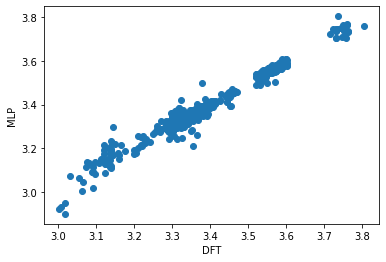

In [11]:
#Plot DFT Band gap energy vs regressor predicted.
plt.scatter(ytest, ypred)# plot the predicted versus the actual gaps
plt.xlabel('DFT')
plt.ylabel('MLP')

## Train a model from scrach 

You can retrain a new model on any amount of the data that you would like to use.
Note - the model will probably take around 8000 epochs to reach the stopping creteria prescribed below (these are the criteria used in the paper).

You can build either the shallow or the deep network using the `shallow_mlp` and `deep_mlp` functions respectively.

In [31]:
# Define MLP architecture. 
model = mlp_deep(dropout_rate=0.3)

In [32]:
# Summarize model trainable parameters. 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8

In [33]:
# Define early stopping parameters. 
stopping =  EarlyStopping(monitor='val_mae', patience=750, verbose=0, mode='auto', restore_best_weights=True)

In [34]:
# Define MLP hyperparameters. 
ad = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False) # Model creation
model.compile(loss='mae', optimizer=ad, metrics=['mae']) # Model config

In [35]:
# Train MLP. 
history = model.fit(Xtrain, ytrain, epochs=10000, batch_size=32, verbose=1, validation_data=(Xval, yval), callbacks=[stopping]) 

Epoch 1/100
4/4 [==============================] - 2s 205ms/step - loss: 3.4231 - mae: 3.4231 - val_loss: 95.9755 - val_mae: 95.9755
Epoch 2/100
4/4 [==============================] - 0s 68ms/step - loss: 3.4259 - mae: 3.4259 - val_loss: 79.4755 - val_mae: 79.4755
Epoch 3/100
4/4 [==============================] - 0s 60ms/step - loss: 3.3886 - mae: 3.3886 - val_loss: 67.9184 - val_mae: 67.9184
Epoch 4/100
4/4 [==============================] - 0s 86ms/step - loss: 3.4752 - mae: 3.4752 - val_loss: 59.9841 - val_mae: 59.9841
Epoch 5/100
4/4 [==============================] - 0s 60ms/step - loss: 3.4194 - mae: 3.4194 - val_loss: 54.1360 - val_mae: 54.1360
Epoch 6/100
4/4 [==============================] - 0s 64ms/step - loss: 3.4483 - mae: 3.4483 - val_loss: 50.4731 - val_mae: 50.4731
Epoch 7/100
4/4 [==============================] - 0s 66ms/step - loss: 3.4402 - mae: 3.4402 - val_loss: 46.7528 - val_mae: 46.7528
Epoch 8/100
4/4 [==============================] - 0s 61ms/step - loss: 3.3

4/4 [==============================] - 0s 48ms/step - loss: 3.2380 - mae: 3.2380 - val_loss: 1.1997 - val_mae: 1.1997
Epoch 64/100
4/4 [==============================] - 0s 90ms/step - loss: 3.2282 - mae: 3.2282 - val_loss: 1.0758 - val_mae: 1.0758
Epoch 65/100
4/4 [==============================] - 0s 80ms/step - loss: 3.2575 - mae: 3.2575 - val_loss: 1.0158 - val_mae: 1.0158
Epoch 66/100
4/4 [==============================] - 0s 67ms/step - loss: 3.1935 - mae: 3.1935 - val_loss: 0.9552 - val_mae: 0.9552
Epoch 67/100
4/4 [==============================] - 0s 84ms/step - loss: 3.2532 - mae: 3.2532 - val_loss: 0.9138 - val_mae: 0.9138
Epoch 68/100
4/4 [==============================] - 0s 83ms/step - loss: 3.1977 - mae: 3.1977 - val_loss: 0.8951 - val_mae: 0.8951
Epoch 69/100
4/4 [==============================] - 0s 74ms/step - loss: 3.2413 - mae: 3.2413 - val_loss: 0.8929 - val_mae: 0.8929
Epoch 70/100
4/4 [==============================] - 0s 61ms/step - loss: 3.1896 - mae: 3.1896 - 

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


Text(0.5, 0, 'Training Epoch')

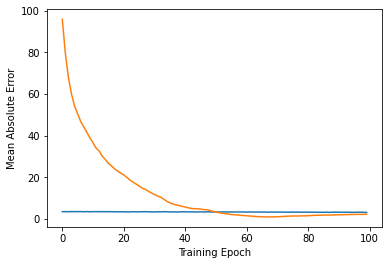

In [37]:
# Plote validation MAE vs number of training epochs. 
print(history.history.keys())
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.ylabel('Mean Absolute Error')
plt.xlabel('Training Epoch')
#plt.ylim(0,1)
#plt.savefig('val-mae-zoom.png')